In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, TensorBoard
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error 
from tensorflow.keras.backend import clear_session
import gc

In [2]:
data = pd.read_csv('all_data_results_cleaned.csv')

In [3]:
to_drop=[
        "outside_diameter", "wall_thickness", "raised_face_depth",
        "w_neck_c", "flange_outer_radius", "flange_thickness_d","raised_face_radius",
        "y_deformation_position", "z_deformation_position",
        "support_right", "support_left"
        ]
to_keep=[
        "pipe_dn","pipe_schedule","flange_class",
        "length1", "length2", "lumped_mass",
        "frequency","x_deformation_position","allowable_deformation","support"
        ]

data.drop(columns=to_drop,inplace=True)

In [4]:
numeric_features = [
    "pipe_dn",
    'length1', 'length2', 'lumped_mass',
    ]
categorical_features = ['support',"pipe_schedule","flange_class"]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop=None), categorical_features)
    ])

In [5]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [6]:
output_columns = ['allowable_deformation', 'frequency', 'x_deformation_position']
x = data.drop(output_columns, axis=1)
y = pd.DataFrame(data[output_columns])

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [8]:
x_train_transformed = pipeline.fit_transform(x_train)
x_test_transformed = pipeline.transform(x_test)

In [9]:
scaler_y_frequency = StandardScaler()
scaler_y_allowed_deformation = StandardScaler()
scaler_y_x_position = StandardScaler()

y_train_transformed_frequency = scaler_y_frequency.fit_transform(pd.DataFrame(y_train["frequency"]))
y_test_transformed_frequency = scaler_y_frequency.transform(pd.DataFrame(y_test["frequency"]))

y_train_transformed_allowable_deformation = scaler_y_allowed_deformation.fit_transform(pd.DataFrame(y_train["allowable_deformation"]))
y_test_transformed_allowable_deformation = scaler_y_allowed_deformation.transform(pd.DataFrame(y_test["allowable_deformation"]))

y_train_transformed_x_displacement = scaler_y_x_position.fit_transform(pd.DataFrame(y_train["x_deformation_position"]))
y_test_transformed_x_displacement = scaler_y_x_position.transform(pd.DataFrame(y_test["x_deformation_position"]))



In [10]:
logdir = "logs/frequency_class/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

In [11]:
input_layer = Input(shape=(x_train_transformed.shape[1],))
hidden1 = Dense(1024, activation='relu')(input_layer)
dropout1 = Dropout(0.2)(hidden1)
"""hidden2 = Dense(256, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(hidden2)"""
hidden3 = Dense(64, activation='relu')(dropout1)

# Separate output for each target variable
output_layer = Dense(1)(hidden3)
#, name='allowable_deformation'


In [12]:
model = Model(inputs=input_layer, outputs=output_layer)

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,073 (324.50 KB)

 Trainable params: 83,073 (324.50 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='mse',
              metrics=["R2Score"])

In [15]:
history = model.fit(
    x_train_transformed, 
    y_train_transformed_frequency,  # Split the targets into separate arrays
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[tensorboard_callback]
)

Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - R2Score: 0.7063 - loss: 0.2824 - val_R2Score: 0.9267 - val_loss: 0.0775
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - R2Score: 0.9158 - loss: 0.0861 - val_R2Score: 0.9373 - val_loss: 0.0663
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - R2Score: 0.9324 - loss: 0.0632 - val_R2Score: 0.9519 - val_loss: 0.0508
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - R2Score: 0.9372 - loss: 0.0591 - val_R2Score: 0.9369 - val_loss: 0.0667
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - R2Score: 0.9486 - loss: 0.0509 - val_R2Score: 0.9506 - val_loss: 0.0522
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - R2Score: 0.9558 - loss: 0.0410 - val_R2Score: 0.9612 - val_loss: 0.0410
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - R2Score: 0.9446 - loss: 0.0550 - val_R2Score: 0.9675 - val_loss: 0.0343
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - R2Score: 0.9647 - loss: 0.0332 - val_R2Score: 0.9649 - 

In [16]:
test_loss, test_mse = model.evaluate(x_test_transformed, y_test_transformed_frequency)
print('Test accuracy:', test_mse)

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - R2Score: 0.9859 - loss: 0.0126
Test accuracy: 0.9835054874420166


In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 249,221 (973.52 KB)

 Trainable params: 83,073 (324.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 166,148 (649.02 KB)

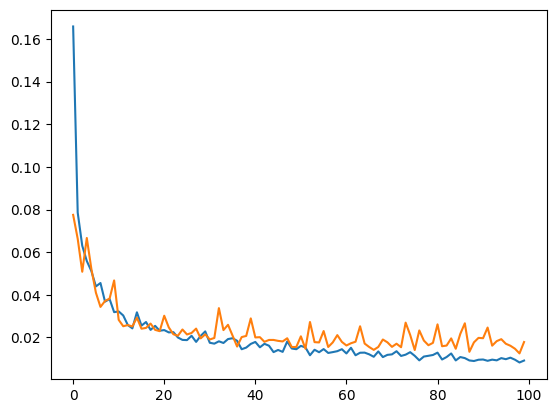

In [18]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")

In [19]:
predictions_scaled = model.predict(x_test_transformed)
predictions = scaler_y_frequency.inverse_transform((predictions_scaled))

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [20]:
x_train_data_solved = model.predict(x_train_transformed)
predictions2 = scaler_y_frequency.inverse_transform((x_train_data_solved))

308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [21]:
predictions2

array([[32.713867 ],
       [65.07048  ],
       [ 5.6075435],
       ...,
       [12.582581 ],
       [11.7021265],
       [14.255685 ]], dtype=float32)

In [22]:
predictions_df = pd.DataFrame(predictions)
print("\nSample Predictions:")
print(predictions_df.head())


Sample Predictions:
           0
0   9.024666
1   3.968462
2  14.331641
3   3.727399
4  20.001225


In [23]:
true= y_test["frequency"].tolist()
pred= predictions_df[0].tolist()
mean_squared_error(true,pred)

8.160467830245725

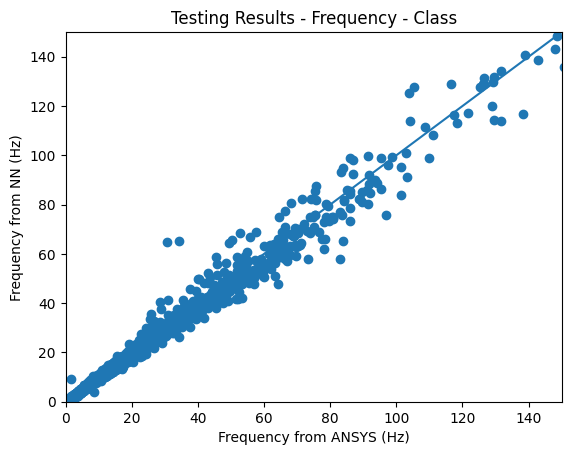

In [24]:
pred=predictions_df
ansys=y_test["frequency"]
plt.scatter(ansys,pred)
#plt.loglog()
plt.plot([0, 150],[0, 150])
plt.xlim(0,150)
plt.ylim(0,150)
plt.xlabel("Frequency from ANSYS (Hz)")
plt.ylabel("Frequency from NN (Hz)")
plt.title("Testing Results - Frequency - Class")
plt.show()

In [23]:
clear_session()
del model
gc.collect()

0